# Explore here

In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import regex as re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

from pickle import dump
from pickle import load

<div class="alert alert-block alert-warning">
<b>Notes:</b> 
<ul>
    <li>Dataset used contains 160000 rows and 4 columns</li>
    <li>From the 'domain' feature we derive 15 new features (domain length, ratios for unique characters, digits, vowels, consonants, entropy, ngrams...)</li>
    <li>There is no feature scaling and transformation!</li>
    <li></li>
</ul>
</div>

# EDA

In [11]:
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-Detection-project2/data/raw/dga_data_full.csv')
df.head()

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   isDGA     160000 non-null  object
 1   domain    159998 non-null  object
 2   host      160000 non-null  object
 3   subclass  160000 non-null  object
dtypes: object(4)
memory usage: 4.9+ MB


In [14]:
print(df.shape)
missing_values = df.isnull().sum()
print(missing_values)
print("")

(160000, 4)
isDGA       0
domain      2
host        0
subclass    0
dtype: int64



In [15]:
# Drop the rows with missing values
df = df.dropna()
print(df.shape)

(159998, 4)


In [16]:
print(f"Dimensions of the data before dropping duplicates: {df.shape}")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
df = df.drop_duplicates()
print(f"Dimensions of the data after dropping duplicates: {df.shape}")

Dimensions of the data before dropping duplicates: (159998, 4)
Number of duplicate rows: 0
Dimensions of the data after dropping duplicates: (159998, 4)


In [17]:
print("Distribution of the target variable 'isDGA': ")
print(f"DGA: {df['isDGA'].value_counts()['dga']}")
print(f"Legit: {df['isDGA'].value_counts()['legit']}")

Distribution of the target variable 'isDGA': 
DGA: 80000
Legit: 79998


In [18]:
# For our first model, we will use the feature named 'domain' and the target variable 'isDGA'. In next experiments we will use other features such as subclass for clustering
df.drop(['host', 'subclass'], axis=1, inplace=True)
df.head()

,isDGA,domain
0,dga,6xzxsw3sokvg1tc752y1a6p0af
1,dga,glbtlxwwhbnpxs
2,dga,xxmamopyipbfpk
3,dga,zfd5szpi18i85wj9uy13l69rg
4,dga,jpqftymiuver


In [10]:
# df.rename(columns={'host': 'domain_name'}, inplace=True)

### Feature Engineering

In [19]:
# We will use the domain_name feature to extract the length of the domain name
df['d_length'] = df['domain'].apply(lambda x: len(x))
df.head()

,isDGA,domain,d_length
0,dga,6xzxsw3sokvg1tc752y1a6p0af,26
1,dga,glbtlxwwhbnpxs,14
2,dga,xxmamopyipbfpk,14
3,dga,zfd5szpi18i85wj9uy13l69rg,25
4,dga,jpqftymiuver,12


In [20]:
df['isDGA'] = df['isDGA'].apply(lambda x: 1 if x == 'dga' else 0)
df.head()

,isDGA,domain,d_length
0,1,6xzxsw3sokvg1tc752y1a6p0af,26
1,1,glbtlxwwhbnpxs,14
2,1,xxmamopyipbfpk,14
3,1,zfd5szpi18i85wj9uy13l69rg,25
4,1,jpqftymiuver,12


In [21]:
# function to get the number of unique characters in a domain name
def unique_char_count(domain):
    return len(set(domain))

df['unique_char_count'] = df['domain'].apply(unique_char_count)
df.head()

,isDGA,domain,d_length,unique_char_count
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21
1,1,glbtlxwwhbnpxs,14,10
2,1,xxmamopyipbfpk,14,10
3,1,zfd5szpi18i85wj9uy13l69rg,25,19
4,1,jpqftymiuver,12,12


In [22]:
# function to get the number of unique letters in a domain name
def unique_letter_count(domain):
    return len(set(re.sub(r'[^a-z]', '', domain)))

df['unique_letter_count'] = df['domain'].apply(unique_letter_count)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14
1,1,glbtlxwwhbnpxs,14,10,10
2,1,xxmamopyipbfpk,14,10,10
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13
4,1,jpqftymiuver,12,12,12


In [23]:
# function to get the number of unique digits in a domain name
def unique_digit_count(domain):
    return len(set(re.sub(r'[^0-9]', '', domain)))

df['unique_digit_count'] = df['domain'].apply(unique_digit_count)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7
1,1,glbtlxwwhbnpxs,14,10,10,0
2,1,xxmamopyipbfpk,14,10,10,0
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6
4,1,jpqftymiuver,12,12,12,0


In [24]:
# function to get the ratio of letters to the length of the domain name
def letter_ratio(domain):
    letters = re.sub(r'[^a-z]', '', domain)
    return len(letters) / len(domain)

df['letter_ratio'] = df['domain'].apply(letter_ratio)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000
2,1,xxmamopyipbfpk,14,10,10,0,1.000000
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000
4,1,jpqftymiuver,12,12,12,0,1.000000


In [25]:
# function to get the ratio of digits to the length of the domain name
def digit_ratio(domain):
    digits = re.sub(r'[^0-9]', '', domain)
    return len(digits) / len(domain)

df['digit_ratio'] = df['domain'].apply(digit_ratio)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846,0.346154
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000,0.000000
2,1,xxmamopyipbfpk,14,10,10,0,1.000000,0.000000
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000,0.400000
4,1,jpqftymiuver,12,12,12,0,1.000000,0.000000


In [26]:
# function to get the ratio of unique letters to unique characters 
def unique_letter_ratio(domain):
    letters = re.sub(r'[^a-z]', '', domain)
    return len(set(letters)) / len(set(domain))

df['unique_letter_ratio'] = df['domain'].apply(unique_letter_ratio)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846,0.346154,0.666667
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000,0.000000,1.000000
2,1,xxmamopyipbfpk,14,10,10,0,1.000000,0.000000,1.000000
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000,0.400000,0.684211
4,1,jpqftymiuver,12,12,12,0,1.000000,0.000000,1.000000


In [27]:
# function to get the ratio of unique digits to unique characters
def unique_digit_ratio(domain):
    digits = re.sub(r'[^0-9]', '', domain)
    return len(set(digits)) / len(set(domain))

df['unique_digit_ratio'] = df['domain'].apply(unique_digit_ratio)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846,0.346154,0.666667,0.333333
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000,0.000000,1.000000,0.000000
2,1,xxmamopyipbfpk,14,10,10,0,1.000000,0.000000,1.000000,0.000000
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000,0.400000,0.684211,0.315789
4,1,jpqftymiuver,12,12,12,0,1.000000,0.000000,1.000000,0.000000


In [28]:
# function to get the ratio of special characters to the length of the domain name
def special_char_ratio(domain):
    special_chars = re.sub(r'[a-z0-9]', '', domain)
    return len(special_chars) / len(domain)

df['special_char_ratio'] = df['domain'].apply(special_char_ratio)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio,special_char_ratio
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846,0.346154,0.666667,0.333333,0.0
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0
2,1,xxmamopyipbfpk,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000,0.400000,0.684211,0.315789,0.0
4,1,jpqftymiuver,12,12,12,0,1.000000,0.000000,1.000000,0.000000,0.0


In [21]:
"""
domain names typically only include hyphens, periods, and alphanumeric characters.
"""

'\ndomain names typically only include hyphens, periods, and alphanumeric characters.\n'

In [29]:
# Function to calculate ratio of consonant characters in domain name
def consonant_ratio(domain):
    consonants = sum(1 for char in domain if char.isalpha() and char.lower() not in 'aeiou')
    return consonants / len(domain)

# Function to calculate ratio of vowels in domain name
def vowel_ratio(domain):
    vowels = sum(1 for char in domain if char.lower() in 'aeiou')
    return vowels / len(domain)

df['consonant_ratio'] = df['domain'].apply(consonant_ratio)
df['vowel_ratio'] = df['domain'].apply(vowel_ratio)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio,special_char_ratio,consonant_ratio,vowel_ratio
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846,0.346154,0.666667,0.333333,0.0,0.538462,0.115385
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000
2,1,xxmamopyipbfpk,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,0.785714,0.214286
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000,0.400000,0.684211,0.315789,0.0,0.480000,0.120000
4,1,jpqftymiuver,12,12,12,0,1.000000,0.000000,1.000000,0.000000,0.0,0.750000,0.250000


In [30]:
# Function to get the length of the longest consonant string
def longest_consonant_string(domain):
    consonants = 'bcdfghjklmnpqrstvwxyzBCDFGHJKLMNPQRSTVWXYZ'
    max_length = 0
    current_length = 0
    for char in domain:
        if char in consonants:
            current_length += 1
            max_length = max(max_length, current_length)
        else:
            current_length = 0
    return max_length

# Function to get the length of the longest vowel sequence
def longest_vowel_string(domain):
    vowels = 'aeiouAEIOU'
    max_length = 0
    current_length = 0
    for char in domain:
        if char in vowels:
            current_length += 1
            max_length = max(max_length, current_length)
        else:
            current_length = 0
    return max_length


# Function to get the length of the longest string of numbers
def longest_number_string(domain):
    numbers = '0123456789'
    max_length = 0
    current_length = 0
    for char in domain:
        if char in numbers:
            current_length += 1
            max_length = max(max_length, current_length)
        else:
            current_length = 0
    return max_length

df['long_consonant_str'] = df['domain'].apply(longest_consonant_string)
df['long_vowel_str'] = df['domain'].apply(longest_vowel_string)
df['long_number_str'] = df['domain'].apply(longest_number_string)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio,special_char_ratio,consonant_ratio,vowel_ratio,long_consonant_str,long_vowel_str,long_number_str
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846,0.346154,0.666667,0.333333,0.0,0.538462,0.115385,5,1,3
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,14,0,0
2,1,xxmamopyipbfpk,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,0.785714,0.214286,5,1,0
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000,0.400000,0.684211,0.315789,0.0,0.480000,0.120000,3,1,2
4,1,jpqftymiuver,12,12,12,0,1.000000,0.000000,1.000000,0.000000,0.0,0.750000,0.250000,7,2,0


In [31]:
# function to get the entropy of a domain name
def entropy(domain):
    p, lns = Counter(domain), float(len(domain))
    return -sum( count/lns * np.log2(count/lns) for count in p.values())

df['entropy'] = df['domain'].apply(entropy)
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio,special_char_ratio,consonant_ratio,vowel_ratio,long_consonant_str,long_vowel_str,long_number_str,entropy
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846,0.346154,0.666667,0.333333,0.0,0.538462,0.115385,5,1,3,4.315824
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,14,0,0,3.235926
2,1,xxmamopyipbfpk,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,0.785714,0.214286,5,1,0,3.182006
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000,0.400000,0.684211,0.315789,0.0,0.480000,0.120000,3,1,2,4.163856
4,1,jpqftymiuver,12,12,12,0,1.000000,0.000000,1.000000,0.000000,0.0,0.750000,0.250000,7,2,0,3.584963


In [32]:
top_english_words = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-Detection-project2/data/raw/google-10000-english.txt', header=None, names=['words'])
d = top_english_words
dump(d, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-Detection-project2/data/raw/top_english_words.pkl', 'wb'))

In [33]:
def ngrams(word, n):    
    l_ngrams = []
    n = n if isinstance(n, list) else [n]
    word = word if isinstance(word, list) else [word]
    
    for w in word:
        for curr_n in n:
            ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
            l_ngrams.extend(ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):    
    l_ngrams = ngrams(domain, n)
    count_sum = sum(d.get(ngram, 0) for ngram in l_ngrams)
    feature = count_sum/(len(domain)-n+1) if len(domain)-n+1 else 0
    return feature
    
def average_ngram_feature(l_ngram_feature):    
    return sum(l_ngram_feature)/len(l_ngram_feature) if l_ngram_feature else 0

dict_freq = { word[0]: num for num, word in enumerate(d.values, 1) }

df['ngrams'] = df['domain'].apply(lambda x: average_ngram_feature([ngram_feature(x, dict_freq, n) for n in [1,2,3]]))
df.head()

,isDGA,domain,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio,special_char_ratio,consonant_ratio,vowel_ratio,long_consonant_str,long_vowel_str,long_number_str,entropy,ngrams
0,1,6xzxsw3sokvg1tc752y1a6p0af,26,21,14,7,0.653846,0.346154,0.666667,0.333333,0.0,0.538462,0.115385,5,1,3,4.315824,390.462051
1,1,glbtlxwwhbnpxs,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,14,0,0,3.235926,1133.379121
2,1,xxmamopyipbfpk,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,0.785714,0.214286,5,1,0,3.182006,1005.406593
3,1,zfd5szpi18i85wj9uy13l69rg,25,19,13,6,0.600000,0.400000,0.684211,0.315789,0.0,0.480000,0.120000,3,1,2,4.163856,382.083333
4,1,jpqftymiuver,12,12,12,0,1.000000,0.000000,1.000000,0.000000,0.0,0.750000,0.250000,7,2,0,3.584963,1477.137879


In [34]:
df.shape

(159998, 18)

In [35]:
df_final = df
df_final = df_final.drop(['domain'], axis=1)
df_final.to_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-Detection-project2/data/processed/dga_features_final.csv', index=False)
df_final.head()

,isDGA,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio,special_char_ratio,consonant_ratio,vowel_ratio,long_consonant_str,long_vowel_str,long_number_str,entropy,ngrams
0,1,26,21,14,7,0.653846,0.346154,0.666667,0.333333,0.0,0.538462,0.115385,5,1,3,4.315824,390.462051
1,1,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,14,0,0,3.235926,1133.379121
2,1,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,0.785714,0.214286,5,1,0,3.182006,1005.406593
3,1,25,19,13,6,0.600000,0.400000,0.684211,0.315789,0.0,0.480000,0.120000,3,1,2,4.163856,382.083333
4,1,12,12,12,0,1.000000,0.000000,1.000000,0.000000,0.0,0.750000,0.250000,7,2,0,3.584963,1477.137879


### Data Visualization

In [36]:
df_final = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-Detection-project2/data/processed/dga_features_final.csv')
df_final.head()

,isDGA,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio,special_char_ratio,consonant_ratio,vowel_ratio,long_consonant_str,long_vowel_str,long_number_str,entropy,ngrams
0,1,26,21,14,7,0.653846,0.346154,0.666667,0.333333,0.0,0.538462,0.115385,5,1,3,4.315824,390.462051
1,1,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,14,0,0,3.235926,1133.379121
2,1,14,10,10,0,1.000000,0.000000,1.000000,0.000000,0.0,0.785714,0.214286,5,1,0,3.182006,1005.406593
3,1,25,19,13,6,0.600000,0.400000,0.684211,0.315789,0.0,0.480000,0.120000,3,1,2,4.163856,382.083333
4,1,12,12,12,0,1.000000,0.000000,1.000000,0.000000,0.0,0.750000,0.250000,7,2,0,3.584963,1477.137879


In [38]:
df_final.describe()

,isDGA,d_length,unique_char_count,unique_letter_count,unique_digit_count,letter_ratio,digit_ratio,unique_letter_ratio,unique_digit_ratio,special_char_ratio,consonant_ratio,vowel_ratio,long_consonant_str,long_vowel_str,long_number_str,entropy,ngrams
count,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000,159998.000000
mean,0.500006,13.467462,10.039750,9.234578,0.772528,0.940217,0.056638,0.943504,0.052796,0.003145,0.659681,0.280536,4.219015,1.382136,0.439230,3.111211,1152.384290
std,0.500002,6.626097,4.082289,3.226055,1.983583,0.144792,0.144753,0.136267,0.135923,0.017919,0.159141,0.144732,3.002512,0.651057,1.195483,0.587741,498.656305
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000
25%,0.000000,9.000000,7.000000,7.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.555556,0.160000,2.000000,1.000000,0.000000,2.750000,819.581026
50%,1.000000,12.000000,9.000000,9.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.666667,0.285714,3.000000,1.000000,0.000000,3.121928,1156.174130
75%,1.000000,15.000000,12.000000,11.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.769231,0.384615,5.000000,2.000000,0.000000,3.461320,1470.775645
max,1.000000,60.000000,32.000000,23.000000,10.000000,1.000000,1.000000,1.000000,1.000000,0.428571,1.000000,1.000000,28.000000,8.000000,20.000000,4.777317,5779.333333


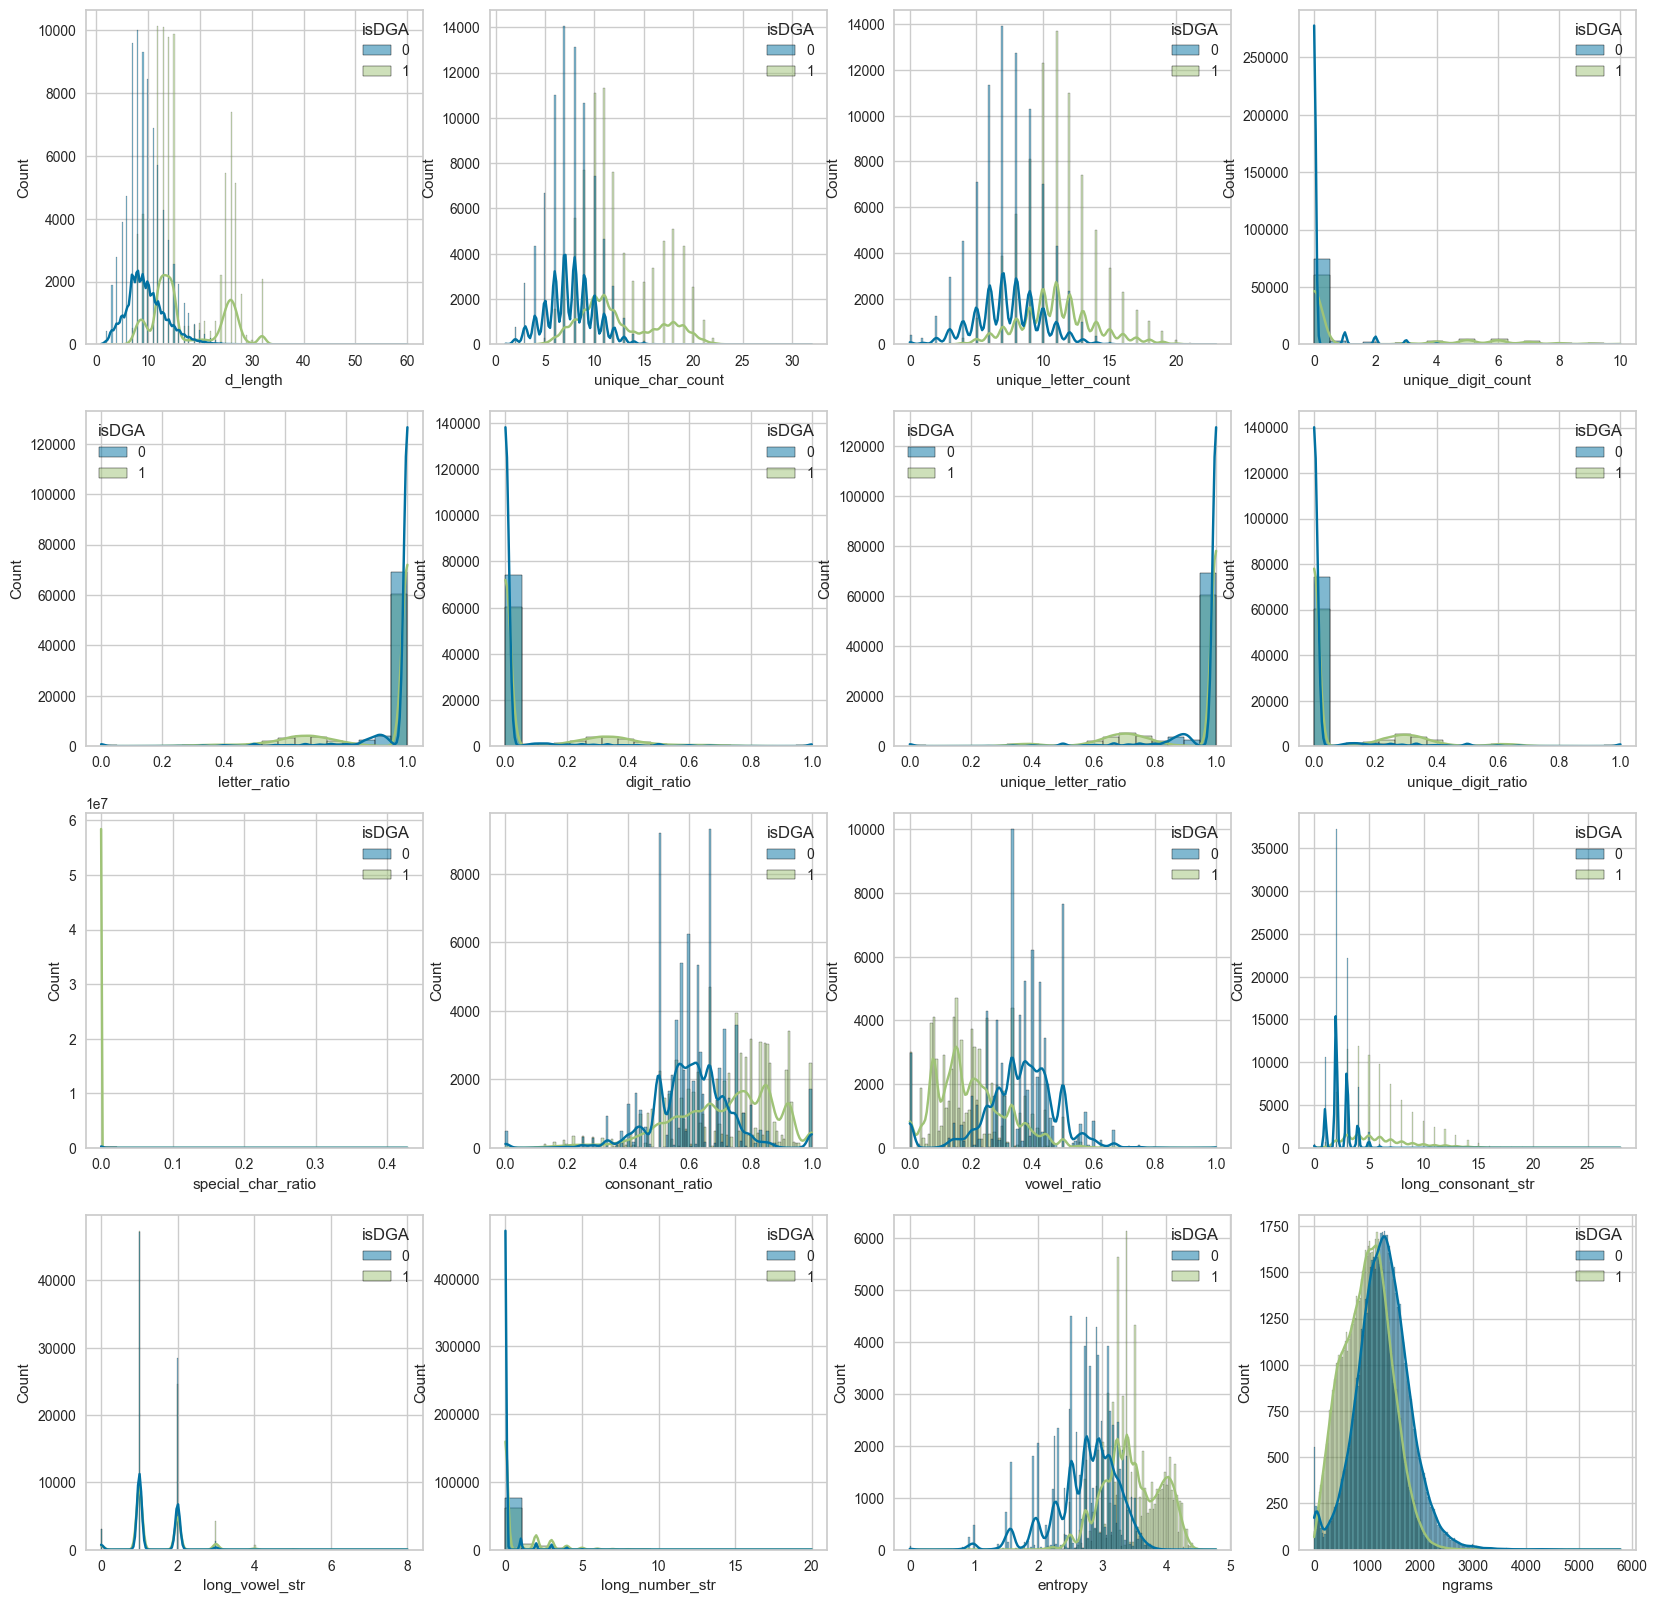

In [39]:
# Let's plot some stuff
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
sns.histplot(data=df_final, x='d_length', hue='isDGA', kde=True, ax=axes[0, 0])
sns.histplot(data=df_final, x='unique_char_count', hue='isDGA', kde=True, ax=axes[0, 1])
sns.histplot(data=df_final, x='unique_letter_count', hue='isDGA', kde=True, ax=axes[0, 2])
sns.histplot(data=df_final, x='unique_digit_count', hue='isDGA', kde=True, ax=axes[0, 3])
sns.histplot(data=df_final, x='letter_ratio', hue='isDGA', kde=True, ax=axes[1, 0])
sns.histplot(data=df_final, x='digit_ratio', hue='isDGA', kde=True, ax=axes[1, 1])
sns.histplot(data=df_final, x='unique_letter_ratio', hue='isDGA', kde=True, ax=axes[1, 2])
sns.histplot(data=df_final, x='unique_digit_ratio', hue='isDGA', kde=True, ax=axes[1, 3])
sns.histplot(data=df_final, x='special_char_ratio', hue='isDGA', kde=True, ax=axes[2, 0])
sns.histplot(data=df_final, x='consonant_ratio', hue='isDGA', kde=True, ax=axes[2, 1])
sns.histplot(data=df_final, x='vowel_ratio', hue='isDGA', kde=True, ax=axes[2, 2])
sns.histplot(data=df_final, x='long_consonant_str', hue='isDGA', kde=True, ax=axes[2, 3])
sns.histplot(data=df_final, x='long_vowel_str', hue='isDGA', kde=True, ax=axes[3, 0])
sns.histplot(data=df_final, x='long_number_str', hue='isDGA', kde=True, ax=axes[3, 1])
sns.histplot(data=df_final, x='entropy', hue='isDGA', kde=True, ax=axes[3, 2])
sns.histplot(data=df_final, x='ngrams', hue='isDGA', kde=True, ax=axes[3, 3])
plt.show()

### CONCLUSIONS

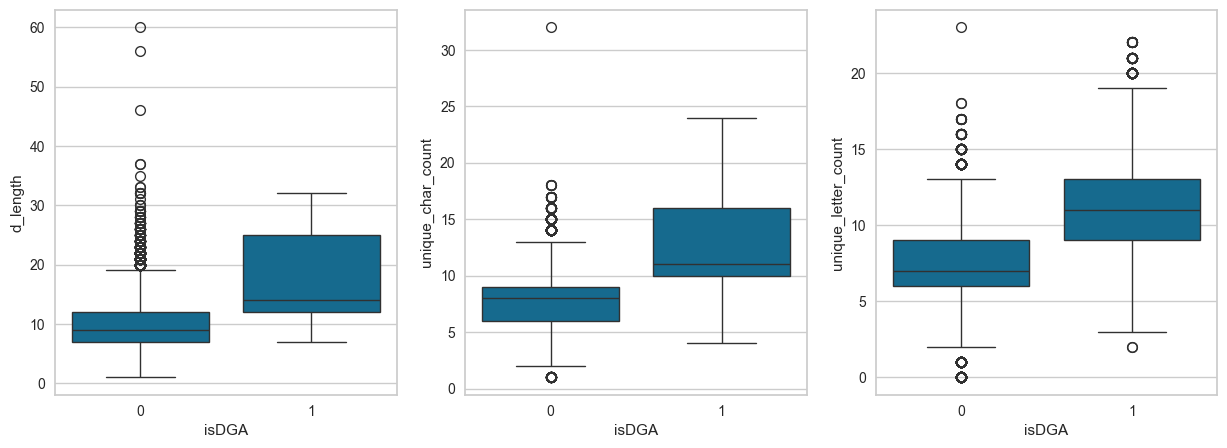

In [40]:
# Box plots for comparing 'd_length' and 'isDGA', 'unique_char_count' and 'isDGA', and 'unique_letter_count' and 'isDGA'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=df_final, x='isDGA', y='d_length', ax=axes[0])
sns.boxplot(data=df_final, x='isDGA', y='unique_char_count', ax=axes[1])
sns.boxplot(data=df_final, x='isDGA', y='unique_letter_count', ax=axes[2])
plt.show()

### CONCLUSIONS

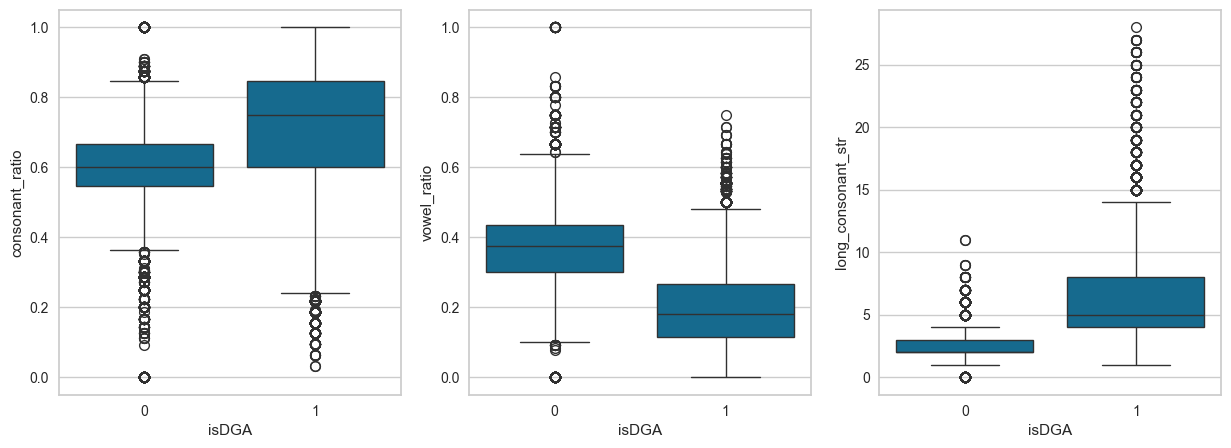

In [41]:
# Box plots for comparing 'unique_digit_count' and 'isDGA', 'letter_ratio' and 'isDGA', and 'digit_ratio' and 'isDGA'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=df_final, x='isDGA', y='consonant_ratio', ax=axes[0])
sns.boxplot(data=df_final, x='isDGA', y='vowel_ratio', ax=axes[1])
sns.boxplot(data=df_final, x='isDGA', y='long_consonant_str', ax=axes[2])
plt.show()

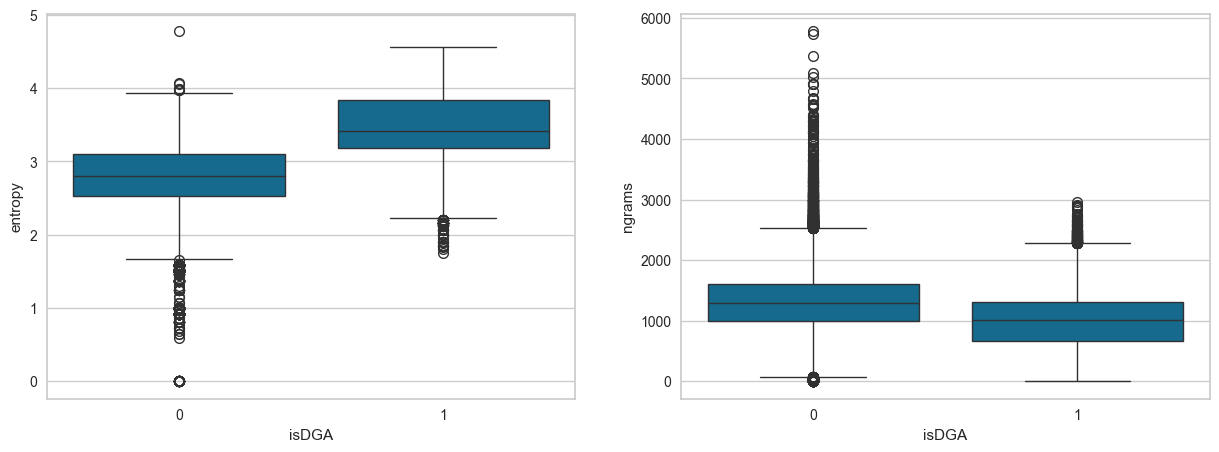

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=df_final, x='isDGA', y='entropy', ax=axes[0])
sns.boxplot(data=df_final, x='isDGA', y='ngrams', ax=axes[1])
plt.show()

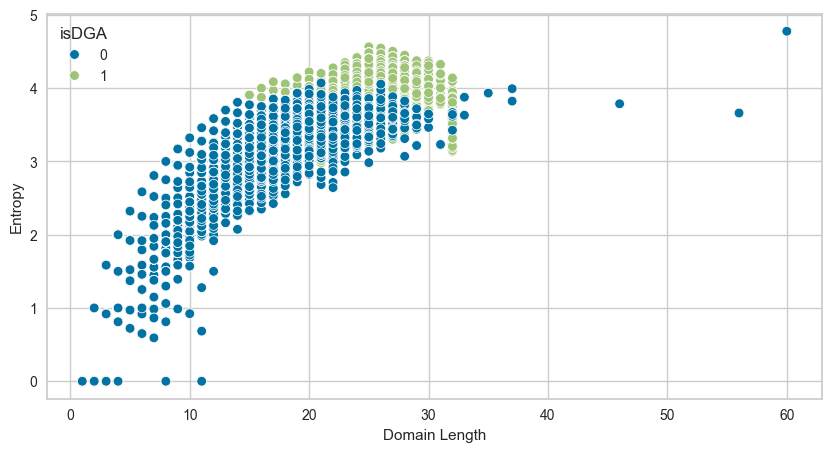

In [43]:
# By using a scatter plot compare 'd_length' and 'entropy' with 'isDGA'
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=df_final, x='d_length', y='entropy', hue='isDGA', ax=ax)
plt.ylabel('Entropy')
plt.xlabel('Domain Length')
plt.show()

### CONCLUSIONS

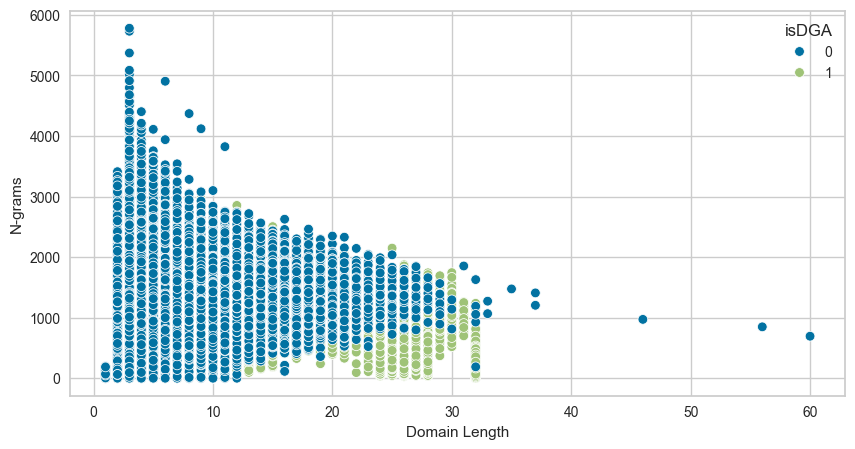

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=df_final, x='d_length', y='ngrams', hue='isDGA', ax=ax)
plt.ylabel('N-grams')
plt.xlabel('Domain Length')
plt.show()

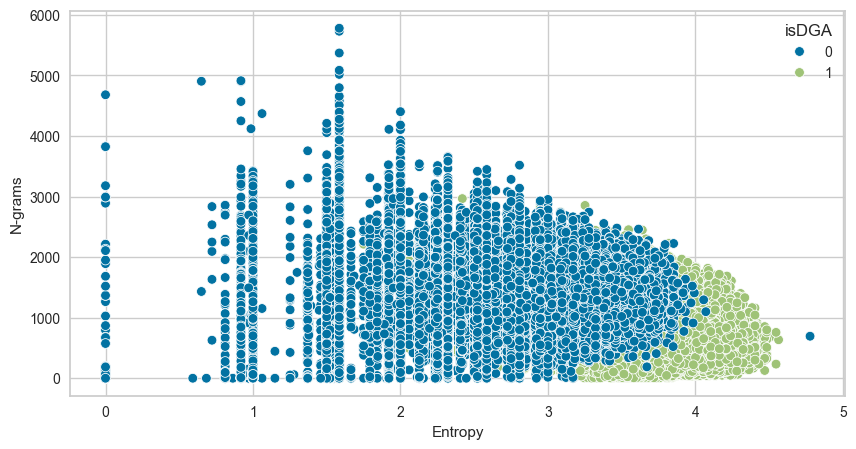

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data=df_final, x='entropy', y='ngrams', hue='isDGA', ax=ax)
plt.ylabel('N-grams')
plt.xlabel('Entropy')
plt.show()

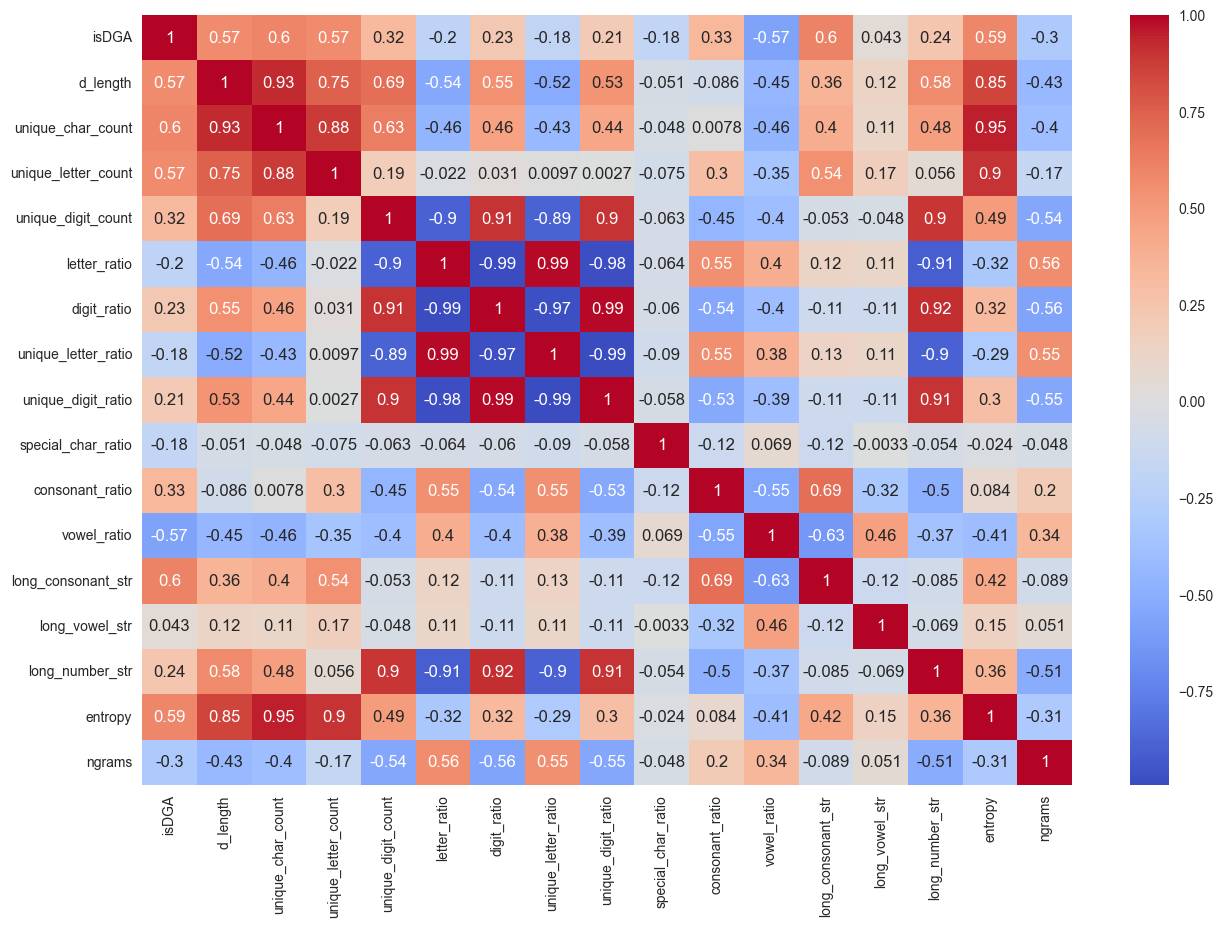

In [47]:
corr = df_final.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

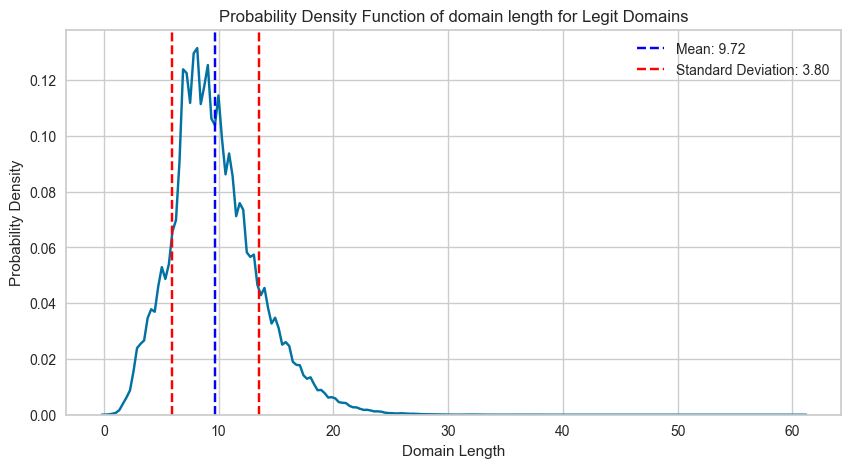

In [53]:
# Plot probability density functions of d_length for Legit domains, add the Mean and Standard Deviation and show these stats in the legend
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(df_final[df_final['isDGA'] == 0]['d_length'], ax=ax)
mean = df_final[df_final['isDGA'] == 0]['d_length'].mean()
std = df_final[df_final['isDGA'] == 0]['d_length'].std()
plt.axvline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(mean + std, color='red', linestyle='--', label=f'Standard Deviation: {std:.2f}')
plt.axvline(mean - std, color='red', linestyle='--')
plt.title('Probability Density Function of domain length for Legit Domains')
plt.xlabel('Domain Length')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

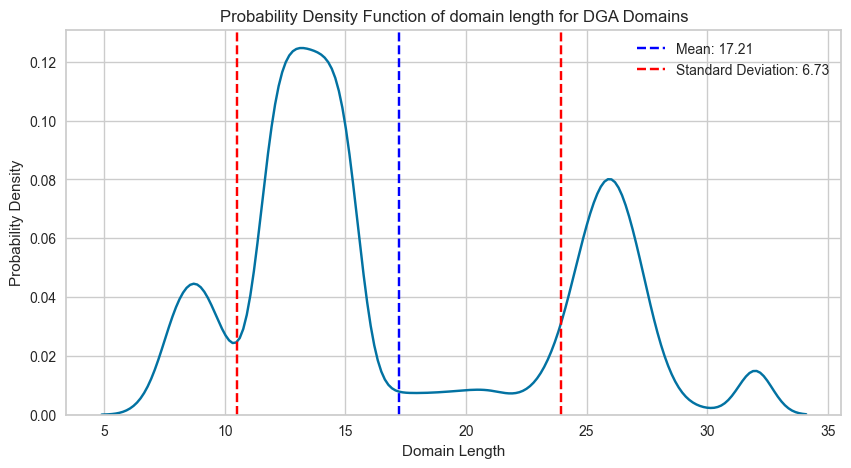

In [54]:
# Plot probability density functions of d_length for DGA domains, add the Mean and Standard Deviation and show these stats in the legend
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(df_final[df_final['isDGA'] == 1]['d_length'], ax=ax)
mean = df_final[df_final['isDGA'] == 1]['d_length'].mean()
std = df_final[df_final['isDGA'] == 1]['d_length'].std()
plt.axvline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(mean + std, color='red', linestyle='--', label=f'Standard Deviation: {std:.2f}')
plt.axvline(mean - std, color='red', linestyle='--')
plt.title('Probability Density Function of domain length for DGA Domains')
plt.xlabel('Domain Length')
plt.ylabel('Probability Density')   
plt.legend()
plt.show()

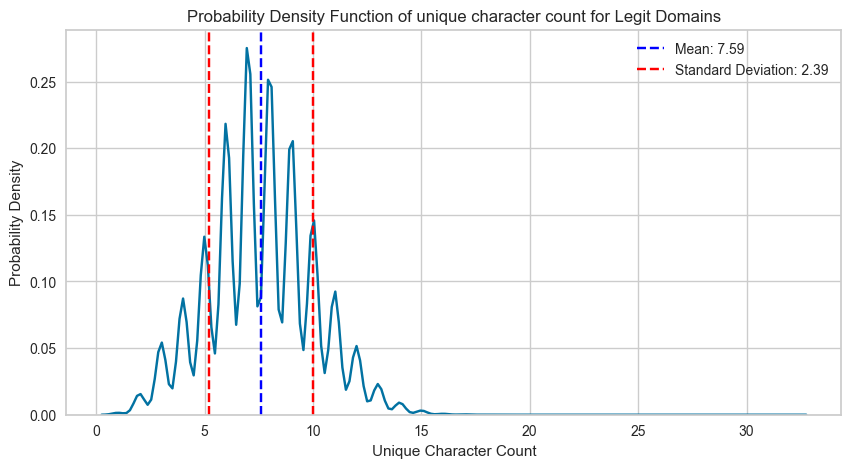

In [55]:
# Plot probability density functions of unique_char_count for Legit domains, add the Mean and Standard Deviation and show these stats in the legend
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(df_final[df_final['isDGA'] == 0]['unique_char_count'], ax=ax)
mean = df_final[df_final['isDGA'] == 0]['unique_char_count'].mean()
std = df_final[df_final['isDGA'] == 0]['unique_char_count'].std()
plt.axvline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(mean + std, color='red', linestyle='--', label=f'Standard Deviation: {std:.2f}')
plt.axvline(mean - std, color='red', linestyle='--')
plt.title('Probability Density Function of unique character count for Legit Domains')
plt.xlabel('Unique Character Count')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

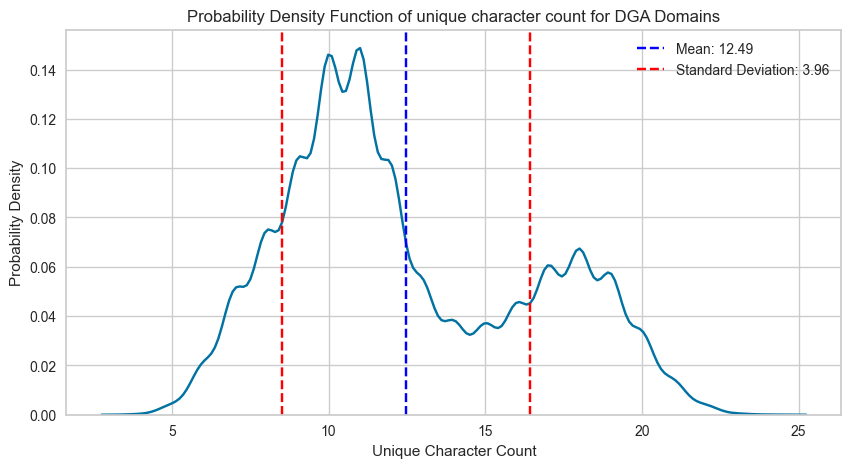

In [56]:
# Plot probability density functions of unique_char_count for DGA domains, add the Mean and Standard Deviation and show these stats in the legend
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(df_final[df_final['isDGA'] == 1]['unique_char_count'], ax=ax)
mean = df_final[df_final['isDGA'] == 1]['unique_char_count'].mean()
std = df_final[df_final['isDGA'] == 1]['unique_char_count'].std()
plt.axvline(mean, color='blue', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(mean + std, color='red', linestyle='--', label=f'Standard Deviation: {std:.2f}')
plt.axvline(mean - std, color='red', linestyle='--')
plt.title('Probability Density Function of unique character count for DGA Domains')
plt.xlabel('Unique Character Count')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

### Feature Selection

In [57]:
# feature selection using SelectKBest
X = df_final.drop('isDGA', axis=1)
y = df_final['isDGA']

selector = SelectKBest(score_func=f_classif, k=9)
X_new = selector.fit_transform(X, y)
X_new.shape
X.columns[selector.get_support()]

Index(['d_length', 'unique_char_count', 'unique_letter_count',
       'unique_digit_count', 'consonant_ratio', 'vowel_ratio',
       'long_consonant_str', 'entropy', 'ngrams'],
      dtype='object')

In [58]:
# using selection_model.scores shows the score how relevant the features are
scores = selector.scores_
scores = pd.DataFrame(scores, index=X.columns, columns=['Score'])
scores.sort_values(by='Score', ascending=False)

,Score
long_consonant_str,91731.180580
unique_char_count,89754.315957
entropy,86843.338905
vowel_ratio,77448.480515
unique_letter_count,77167.578650
d_length,75158.532847
consonant_ratio,20050.144858
unique_digit_count,18570.668014
ngrams,16206.207351
long_number_str,9820.356793


In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [60]:
# Before creating the model, let's print the dimensions of the training and testing sets
print(f"The entire dataset has {df_final.shape[0]} rows and {df_final.shape[1]} columns.")
print(f"Dimensions of the training set: {X_train.shape}")
print(f"Dimensions of the testing set: {X_test.shape}")
print(f"Dimensions of the training target set: {y_train.shape}")
print(f"Dimensions of the testing target set: {y_test.shape}")


The entire dataset has 159998 rows and 17 columns.
Dimensions of the training set: (127998, 9)
Dimensions of the testing set: (32000, 9)
Dimensions of the training target set: (127998,)
Dimensions of the testing target set: (32000,)


In [61]:
y_train

138894    0
115279    0
129928    0
74987     1
36702     1
         ..
119879    0
103694    0
131932    0
146867    0
121958    0
Name: isDGA, Length: 127998, dtype: int64

In [62]:
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [63]:
y_pred = dt_clf.predict(X_test)

In [64]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Decision Tree Classifier: %.2f%%" % (accuracy * 100.0))

Accuracy of the Decision Tree Classifier: 86.11%
